In [58]:
import pandas as pd
import numpy as np
from os import getcwd, path

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn

import matplotlib.pyplot as plt

from collections import defaultdict

plt.style.use('ggplot')

## Parameters

In [2]:
sent_tokenizer = False
use_pretrained_embeddings = True
use_nltk_cleaning = False
use_tfidf_tokenizer = True
use_keras_tokenizer = False
use_tfidf_as_embedding_weights = True

## Functions

In [3]:
def plot_history(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
def create_embedding_matrix(filepath, word_index, embedding_dim):
    
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

## Data Ingest

In [4]:
data_dir = 'D:/Data_Science/ClassificationProblems/Sentiment_Analysis/data/SA_4_Categories.csv'
Corpus = pd.read_csv(data_dir ,encoding='latin-1', sep = ';')


In [5]:
Corpus.head()

,text,label
0,The stable way of business life many corporate...,0
1,"As dozens of companies have already learned, s...",0
2,What capabilities will a profitable internatio...,0
3,Almost every kind of manufacturer will have to...,0
4,Some companies have already responded to the g...,0


In [6]:
Corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1609 entries, 0 to 1608
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1609 non-null   object
 1   label   1609 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 25.3+ KB


## 1. NLTK - Data preprocessing

- I. Remove Blank rows in Data, if any
- II. Change all the text to lower case
- III. Word Tokenization
- IV. Remove Stop words
- V. Remove Non-alpha text
- VI. Word Lemmatization

In [7]:
if use_nltk_cleaning:

    # Step I : Remove blank rows if any.
    Corpus['text'].dropna(inplace=True)

    # Step II : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
    # Corpus['text'] = Corpus['text'].apply(lambda x: str(x).lower())
    Corpus['text'] = [x.lower() for x in Corpus['text']]

    # Step III : Tokenization : In this each entry in the corpus will be broken into set of words
    if sent_tokenizer: 
        Corpus['text'] = [sent_tokenize(x) for x in Corpus['text']] 
    else:
        #Corpus['text'] = Corpus['text'].apply(lambda x: str(word_tokenize(x)) )
        Corpus['text'] = [word_tokenize(x) for x in Corpus['text']]

    # Step IV, V, VI : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
    # WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
    # Word Classification for Lemmatizer https://www.nltk.org/_modules/nltk/corpus/reader/wordnet.html
    # https://www.geeksforgeeks.org/defaultdict-in-python/
    tag_map = defaultdict(lambda: wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV

    # Execute Word Tagging
    for index, entry in enumerate(Corpus['text']):

        # Declaring Empty List to store the words that follow the rules for this step
        lemma_words = []

        # Initializing WordNetLemmatizer()
        word_Lemmatized = WordNetLemmatizer()

        # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
        # Posttagging reference : https://www.nltk.org/book/ch05.html 

        for word, tag in pos_tag(entry):

            # Below condition is to check for Stop words and consider only alphabets
            # List of stop words https://gist.github.com/sebleier/554280, https://www.nltk.org/book/ch02.html

            # NLTK check for an alphabetic word https://tedboy.github.io/nlps/generated/generated/nltk.text_type.isalpha.html
            if word not in stopwords.words('english') and word.isalpha():

                # Reference https://www.geeksforgeeks.org/python-lemmatization-with-nltk/
                # Use first letter of NLTK Postagging as "pos" parameter mapping it through the dict tag_map
                lemma_word = word_Lemmatized.lemmatize(word = word,
                                                       pos = tag_map[tag[0]]  )
                # Append word back to the empty list
                lemma_words.append(lemma_word)

        # The final processed set of words for each iteration will be stored in 'text_final'
        Corpus.loc[index,'text_clean'] = str(lemma_words)
    
    Corpus.loc[:,'text'] = Corpus['text_clean']

## 2. Prepare Trainig and Test data

In [10]:
sentences = Corpus['text'].values
y = Corpus['label'].values

sentences_train, sentences_test, Y_train, Y_test = train_test_split( sentences, y, test_size=0.25)

# Use Label encoder for the expected output
Encoder = LabelEncoder()
Y_train = Encoder.fit_transform(Y_train)
Y_test = Encoder.fit_transform(Y_test)

In [52]:
np.unique(Y_test)

array([0, 1, 2, 3, 4], dtype=int64)

## 3. Word Tokenizer 

In [39]:
# Append "0" add the sentences ending to have equal sentences length
seq_input_len = 100

use_keras_tokenizer = True
use_tfidf_tokenizer = False

if use_keras_tokenizer:
    # Start Tokenizer Object
    tokenizer = Tokenizer(num_words=5000)

    # Train vocabulary
    tokenizer.fit_on_texts(sentences_train)

    X_train = tokenizer.texts_to_sequences(sentences_train)
    X_test = tokenizer.texts_to_sequences(sentences_test)

    vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
   
    vocab = tokenizer.word_index

    X_train = pad_sequences(X_train, padding='post', maxlen=seq_input_len)
    X_test = pad_sequences(X_test, padding='post', maxlen=seq_input_len)

if use_tfidf_tokenizer:
    # Create new Class TfidfVectorizer with max 5000 features
    Tfidf_vect = TfidfVectorizer(max_features=5000)

    # Learn vocabulary and idf from training set
    Tfidf_vect.fit(Corpus['text'])

    # Transfor both the train and the test to document-term matrix
    X_train = Tfidf_vect.transform(sentences_train)
    X_test = Tfidf_vect.transform(sentences_test)
    
    vocab = list(Tfidf_vect.vocabulary_.keys())
    
    vocab_size = len(vocab) + 1
    

## 4. Use pre-trained Embedding Space ( GloVe )

In [15]:
if use_tfidf_as_embedding_weights: 
     
    # Create new Class TfidfVectorizer with max 5000 features
    Tfidf_vect = TfidfVectorizer(max_features=5000)

    # Learn vocabulary and idf from training set
    Tfidf_vect.fit(Corpus['text'])

    # Transfor both the train and the test to document-term matrix
    embedding_matrix = Tfidf_vect.transform(sentences_train)
    
    # Calculate embedding dimension - sequence length
    embedding_dim = len(embedding_matrix.toarray()[1])
    
if use_pretrained_embeddings: 
    
    embedding_dim = 50
    
    embedding_matrix = create_embedding_matrix(
     filepath = 'D:/Semillero Data Science/Deep Learning/pre-trained Word Embeddings/GloVe/glove.6B.50d.txt',
     word_index = vocab, 
     embedding_dim = embedding_dim)

## 4. Set up CNN Model 

In [60]:
# Initialize Model
epochs = 30
batch_size = 64
#output_label = len(np.unique(Y_test))
output_label = 1

model = Sequential()

if use_pretrained_embeddings:  
  
    model.add(layers.Embedding(vocab_size, embedding_dim, 
                               weights = [embedding_matrix], 
                               input_length = seq_input_len, 
                               trainable = False))
else: 
    embedding_dim = 100 # Output Dimension
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))

# Filters: No. of output filter in the convolution
# kernel_size: An integer or tuple/list of a single integer, specifying the length of the 1D convolution window.
model.add(layers.Conv1D(filters = 128, kernel_size = 2, activation='relu'))

# Global max pooling operation for 1D temporal data.
# Downsamples the input representation by taking the maximum value over the time dimension
#model.add(layers.GlobalMaxPooling1D())
model.add(layers.Conv1D(filters = 32, kernel_size = 3, activation='relu'))

model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dense(10, activation='relu'))

model.add(layers.Dense(output_label, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 50)           154300    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 99, 128)           12928     
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 97, 32)            12320     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                330       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 11        
Total params: 179,889
Trainable params: 25,589
Non-trainable params: 154,300
___________________________________________

## 6. Run Model

In [54]:
%timeit

history = model.fit(X_train, Y_train,
                    epochs = epochs,
                    verbose = False,
                    validation_data = (X_test, Y_test),
                    batch_size = batch_size)

loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

ValueError: in user code:

    c:\users\user\anaconda3\envs\class\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    c:\users\user\anaconda3\envs\class\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\user\anaconda3\envs\class\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\user\anaconda3\envs\class\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\user\anaconda3\envs\class\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\user\anaconda3\envs\class\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    c:\users\user\anaconda3\envs\class\lib\site-packages\tensorflow\python\keras\engine\training.py:756 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    c:\users\user\anaconda3\envs\class\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    c:\users\user\anaconda3\envs\class\lib\site-packages\tensorflow\python\keras\losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    c:\users\user\anaconda3\envs\class\lib\site-packages\tensorflow\python\keras\losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    c:\users\user\anaconda3\envs\class\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    c:\users\user\anaconda3\envs\class\lib\site-packages\tensorflow\python\keras\losses.py:1537 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    c:\users\user\anaconda3\envs\class\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    c:\users\user\anaconda3\envs\class\lib\site-packages\tensorflow\python\keras\backend.py:4833 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    c:\users\user\anaconda3\envs\class\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 5) are incompatible


## Recurrent Neural Networks

In [56]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length = seq_input_len))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(1, activation='softmax'))
model.add(layers.Dense(10, activation='softmax'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Training Accuracy: 0.7728
Testing Accuracy:  0.7692


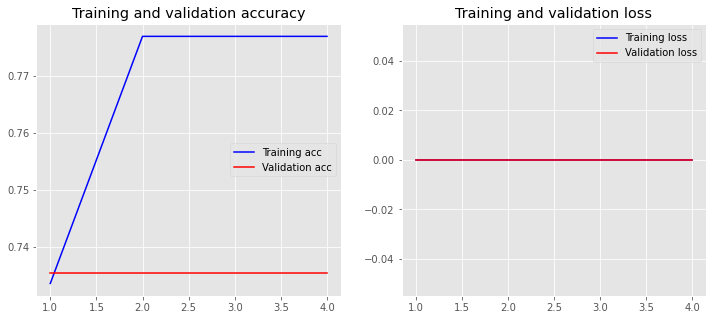

In [61]:
history = model.fit(X_train, 
                    Y_train, 
                    epochs = epochs, 
                    batch_size = batch_size,
                    validation_data = (X_test, Y_test), 
                    validation_split=0.1,
                    verbose = False,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)